In [5]:
%reset
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
#import matplotlib.pyplot as plt
import torch

import defmod as dm

#torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dim = 2
nb_pts = 10
sigma = 1
manifold = dm.manifold.Landmarks(dim, nb_pts)

gd = torch.zeros(nb_pts, dim)
manifold.fill_gd(gd.view(-1))

#scal = dm.deformationmodules.LocalScaling(manifold, sigma)
scal = dm.deformationmodules.GlobalScaling(manifold, sigma)


In [7]:
point = torch.tensor([1,0.]).view(1,2)

In [8]:
scal.fill_controls(1)
scal.field_generator()(point)

tensor([[0.3151, 0.0000]], grad_fn=<AsStridedBackward>)

In [9]:
scal.controls * scal.f_vectors(gd)

tensor([[ 1.0000,  0.0000],
        [-0.5000,  0.8660],
        [-0.5000, -0.8660]])

In [10]:
from defmod.usefulfunctions import grid2vec

grid_origin = [-5,-5]
grid_size = [10,10]
grid_resolution = [20,20]
x, y = torch.meshgrid([
    torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
    torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

gridpos = grid2vec(x, y)

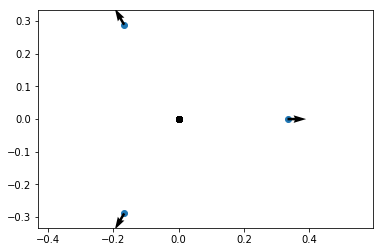

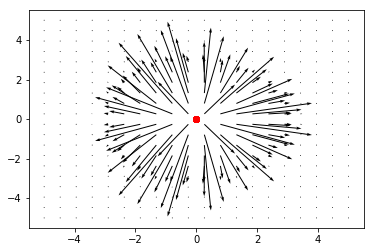

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(scal.f_support(gd)[:,0], scal.f_support(gd)[:,1])
plt.quiver(scal.f_support(gd)[:,0], scal.f_support(gd)[:,1], scal.f_vectors(gd)[:,0], scal.f_vectors(gd)[:,1])
plt.scatter(gd[:,0], gd[:,1], c='k')
plt.axis('equal')
plt.show()

def_grid = scal.field_generator()(gridpos)
plt.figure()
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpos.detach()[:,0], gridpos.detach()[:,1], def_grid.detach()[:,0], def_grid.detach()[:,1])
plt.show()


In [35]:
rot = dm.deformationmodules.LocalRotation(dm.manifold.Landmarks(dim, 1, gd=torch.tensor([0.,0.])), sigma=2.)

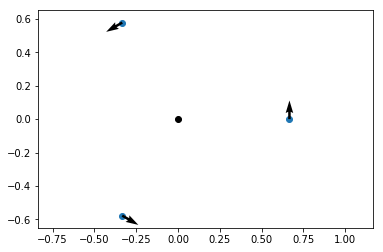

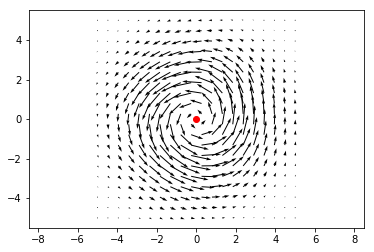

In [36]:
rot.fill_controls(torch.tensor([5.], requires_grad=True))

gd = torch.tensor([0.,0.]).view(-1,2)
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(rot.f_support(gd)[:,0], rot.f_support(gd)[:,1])
plt.quiver(rot.f_support(gd)[:,0], rot.f_support(gd)[:,1], rot.f_vectors(gd)[:,0], rot.f_vectors(gd)[:,1])
plt.scatter(gd[:,0], gd[:,1], c='k')
plt.axis('equal')
plt.show()

def_grid = rot.field_generator()(gridpos)
plt.figure()
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpos.detach()[:,0], gridpos.detach()[:,1], def_grid.detach()[:,0], def_grid.detach()[:,1])
plt.axis('equal')
plt.show()


In [38]:
rot(torch.tensor([2.,0.]).view(-1,2))

tensor([[0.0000, 1.5753]], grad_fn=<AsStridedBackward>)

In [15]:
def test_gradcheck_autoaction():
    def autoaction(mom):
        #scal.manifold.fill_gd(scal.manifold.roll_gd([gd]))
        scal.manifold.fill_cotan(scal.manifold.roll_cotan([mom]))

        return scal.autoaction()


    gd = scal.manifold.unroll_gd()
    mom = scal.manifold.unroll_cotan()

    return torch.autograd.gradcheck(autoaction, (mom), raise_exception=True)


test_gradcheck_autoaction()

True

In [17]:
def test_gradcheck_geo_cont():
    def autoaction(mom):
        #scal.manifold.fill_gd(scal.manifold.roll_gd([gd]))
        scal.manifold.fill_cotan(scal.manifold.roll_cotan([mom]))
        scal.compute_geodesic_control(scal.manifold)
        return scal.controls


    gd = scal.manifold.unroll_gd()
    mom = scal.manifold.unroll_cotan()

    return torch.autograd.gradcheck(autoaction, (mom), raise_exception=True)


test_gradcheck_geo_cont()

True